# Project 1: MinHash and finding similar items

## Part 1: Jaccard Similarity and Shingles

In [1]:
# this piece of code is here to help wiht development using python module `plagiarism_lib`
%load_ext autoreload
%autoreload 2

The `plagiarism_lib` module includes a function to shingle documents. Here is an example of how to use it:

In [2]:
import plagiarism_lib.article_db as art_db

shingles = art_db._shingle_text('The cat in the hat', 2)
print(shingles)

{'ca', 'ha', 'nt', 'eh', 'he', 'ec', 'th', 'ti', 'in', 'at'}


Use this function to answer the following questions

In [3]:
# question 1: What is the jaccard similarity of these two sentences using 2-shingles:
s1 = "I would drink black tea"
s2 = "I would drink green tea"

sh1 = art_db._shingle_text(s1, 2)
sh2 = art_db._shingle_text(s2, 2)

len(sh1.intersection(sh2)) / len(sh1.union(sh2))

0.4782608695652174

In [4]:
# question 2: What is the jaccard similarity of these two sentences using 2-shingles:
s1 = "I would drink green tea but I would not drink black tea"
s2 = "I would not drink green tea but I would drink black tea"

sh1 = art_db._shingle_text(s1, 2)
sh2 = art_db._shingle_text(s2, 2)

len(sh1.intersection(sh2)) / len(sh1.union(sh2))

1.0

In [5]:
# question 3, what is the smallest shingle length we need to use 
# to distinguish these two sentences

s1 = "I would drink green tea but I would not drink black tea"
s2 = "I would not drink green tea but I would drink black tea"

sh1 = art_db._shingle_text(s1, 7)
sh2 = art_db._shingle_text(s2, 7)

print(len(sh1.intersection(sh2)) / len(sh1.union(sh2)))
print('The shingle has to be a length of at least 7 to distinguish between the two sentences')

0.8974358974358975
The shingle has to be a length of at least 7 to distinguish between the two sentences


## Fetch data

Run the following piece of code to fetch data to use in the project, and to setup experiment code

In [6]:
import plagiarism_lib.fetch_data as fetch
import plagiarism_lib.jaccard_experiment as jaccard_exp

import pandas as pd

In [7]:
# fetch small dataset from data repository
DATA_PATH = 'data'

fetch.fetch_data(path=DATA_PATH, maxsize=1000)

In [8]:
DATA_PATH = 'data'
train_file = DATA_PATH + '/articles_1000.train'
truth_file = DATA_PATH + '/articles_1000.truth'
numDocs = 1000
numHashes = 10
import os

RESDIR_PATH = 'result_data'
if not os.path.isdir(RESDIR_PATH):
    os.mkdir(RESDIR_PATH)
    
jaccard_exp_csv = RESDIR_PATH + '/jaccard_exp_res.csv'

In [9]:
DATA_PATH = 'data'
train_file = DATA_PATH + '/articles_1000.train'
truth_file = DATA_PATH + '/articles_1000.truth'

import os

RESDIR_PATH = 'result_data'
if not os.path.isdir(RESDIR_PATH):
    os.mkdir(RESDIR_PATH)
    
jaccard_exp_csv = RESDIR_PATH + '/jaccard_exp_res.csv'

## Jaccard similarity

**TODO** Finish implementing the function `plagiarism_lib.jaccard._jaccard_similarity` to compute the Jaccard Similarity of two sets.

Once you do that run the next chunk to perform an experiment on the effect of shard-length $k$ on Jaccard similarity of
plagiarism instances versus instances that are not plagiarized.

Make sure you set `RUN_JACCARD_EXP = True` to get your experiment data


In [10]:
s1 = train_file
s2 = truth_file

sh1 = art_db._shingle_text(s1, 2)
sh2 = art_db._shingle_text(s2, 2)

len(sh1.intersection(sh2)) / len(sh1.union(sh2))

0.8260869565217391

In [11]:
# run this if needed
RUN_JACCARD_EXP = True
if RUN_JACCARD_EXP:
    exp_res = jaccard_exp.run_experiment(train_file, truth_file)
    exp_res.to_csv(jaccard_exp_csv, index=False)
else:
    exp_res = pd.read_csv(jaccard_exp_csv)

Processing data for k= 2
Processing data for k= 5
Processing data for k= 10
Processing data for k= 20
Processing data for k= 40
Processing data for k= 60
Processing data for k= 120


The following code makes a plot with $k$ in the x-axis and average Jaccard similarity in the y-axis with two lines:
one for plagiarism instances, one for instances that are not plagiarism.

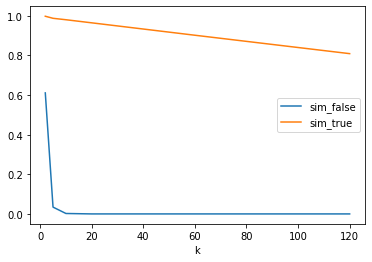

In [12]:
%matplotlib inline

import matplotlib.pyplot as plt

# start here just to make plot
plot_df = exp_res.melt(id_vars=['k'])

fig, ax = plt.subplots()
labels = []

for key, grp in plot_df.groupby('variable'):
    ax = grp.plot(ax=ax, kind='line', x='k', y='value')
    labels.append(key)
lines, _ = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')
plt.show()

**TODO**: Comment on what you observe from this experiment.
 
As k increases the similarity score of non-matches decreases until k=~10 when the score becomes zero. However, as k increases the similarity score of matches linearly decreases. This means that the results are optimized at a certain value for k(in this case 10) and past this point there are no gains for distinguishing between non-matches, but there will be a loss in accurately distinguishing between matches. 
 

## Part 2: MinHash and Jaccard Similarity

Load article data, preprocess it and shingle articles with length $k=10$



In [13]:
from plagiarism_lib.article_db import ArticleDB

artdb = ArticleDB(train_file)
exp_data = artdb.shingle_data(k=10)

Compute Jaccard similarities for pairs of articles in corpus. Set `RUN_MAKE_JS_DF=True` to prepare data on Jaccard similarity for our experiment.

In [14]:
import plagiarism_lib.minhash_experiment as minhash_exp
import pandas as pd

js_csv_file = RESDIR_PATH + '/js_df.csv'

# Switch True/False to run as needed
RUN_MAKE_JS_DF = True

if RUN_MAKE_JS_DF:
    exp_df = minhash_exp.make_js_df(exp_data, artdb._docids)
    exp_df.to_csv(js_csv_file, index=False)
else:
    exp_df = pd.read_csv(js_csv_file)

**TODO**: Finish implementing function `plagiarism_lib.minhash._make_minhash_sigmatrix` to construct the minhash signature matrix of the document collection.

**TODO**: Finish implementing function `plagiarism_lib.minhash.MinHash.get_similarity` to compute the minhash estimate of Jaccard similarity given two minhash signatures.

Once you have completed the above todos, let's compute minhash similarity matrices with varying number of hash functions and compute Jaccard similarity estimates. Set `RUN_MAKE_MH_DF=True` and run the following chunk.

In [15]:
mh_csv_file = RESDIR_PATH + '/mh_df.csv'

hash_vals = [10, 20, 50, 100]
RUN_MAKE_MH_DF = True
if RUN_MAKE_MH_DF:
    minhash_exp.run(exp_data, exp_df, hash_vals=hash_vals)
    exp_df.to_csv(mh_csv_file, index=False)
else:
    exp_df = pd.read_csv(mh_csv_file)

Doing minhash for  10  hashes
Doing minhash for  20  hashes
Doing minhash for  50  hashes
Doing minhash for  100  hashes


The following chunk computes the error of minhash similarity estimates. We are going to use that to see what the effect of the number of hashes used in the minhash signature affects the error of the MinHash estimate of Jaccard similarity.


In [16]:
rmse_df = minhash_exp.post_process_df(exp_df, hash_vals)

The following chunk plots root mean squared error between minhash JS estimate and exact Jaccard similarity

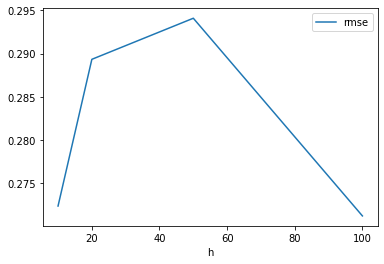

In [17]:
%matplotlib inline

import matplotlib.pyplot as plt


#fig, ax = plt.subplots()
rmse_df.plot(x='h',y='rmse')#, ax=ax)
plt.show()

**TODO**: Comment on the effect of the number of hashes used in the minhash signature matrix and the error of the MinHash estimate.
This appears to change with each run. On the first run the more hashes that were used the lower the mse was. Although there was a slight increase in the mse from 20-50 hashes. This means that in general the more hashes that are used the lower the error will be. On the second run the mse increased as the number of hashes went from 0-20 and than began to decrease as the number of hashes went from 20-100.

## Part 3: LSH

Prepare article database for training file, using $k=10$ for shingles

In [18]:
import plagiarism_lib.lsh_experiment as lsh_exp
from plagiarism_lib.article_db import ArticleDB
from plagiarism_lib.minhash import invert_shingles, MinHash
from pathlib import Path

numdocs = 1000
trainfile = DATA_PATH + '/articles_%d.train' % numdocs

k = 10
print("Preparing Data")
artdb = ArticleDB(trainfile)
inv_data, docids = invert_shingles(artdb.shingle_data(k))

Preparing Data


Compute the minhash signature matrix with 100 rows (hash functions)

In [19]:
num_hash = 100
mh_mat_file = RESDIR_PATH + '/mh_mat_%d_%d_%d.npy' % (numdocs, k, num_hash)

mh = MinHash(num_hash)
if Path(mh_mat_file).is_file():
    print("Loading MH signature matrix from file")
    mh.from_file(docids, mh_mat_file)
else:
    print("Creating minhash matrix with %d hashes" % num_hash)
    mh.make_matrix((inv_data, docids), inverted=True) 
    mh.save_matrix(mh_mat_file)

Loading MH signature matrix from file


In [20]:
mh_df = pd.read_csv('result_data/mh_df.csv')

In [21]:
mh_df

,doci,docj,js,mh_10,mh_20,mh_50,mh_100
0,t120,t121,0.019282,0.50,0.425,0.49,0.435
1,t120,t122,0.002433,0.50,0.475,0.46,0.410
2,t120,t123,0.001127,0.50,0.450,0.47,0.400
3,t120,t124,0.000793,0.50,0.375,0.43,0.390
4,t120,t125,0.066785,0.45,0.450,0.45,0.385
...,...,...,...,...,...,...,...
499495,t9944,t9946,0.001132,0.50,0.500,0.47,0.485
499496,t9944,t9947,0.005220,0.45,0.500,0.44,0.435
499497,t9945,t9946,0.001472,0.45,0.500,0.45,0.460
499498,t9945,t9947,0.002175,0.50,0.500,0.45,0.455


**TODO**: Finish implementing function `plagiarism_lib.lsh._do_lsh` to implement Locality Sensitive Hashing.

Once that is done, run an experiment of using LSH with desired similarity threshold values to detect plagiarism. Set `RUN_LSH_EXP=True` and run the following chunk.

In [27]:
# if YearWinLoseTotalHard2 != 0:
#    YearWinLosePercent3 = float(YearWinLose1)/float(YearWinLoseTotalHard2)*100
#else:
#    print '0'

import plagiarism_lib.lsh_experiment as lsh_exp

DEFAULT_TS = [.01, .05, .10, .30, .50, .70, .90, .95, .99]

truthfile = DATA_PATH + '/articles_%d.truth' % numdocs

csv_file = RESDIR_PATH + '/csv_file.csv'

RUN_LSH_EXP = False # I had to change this to false or I got a ZeroDivisionError: float division by zero
if RUN_LSH_EXP:  
    exp_df = lsh_exp.run(mh, truthfile, ts=DEFAULT_TS)
    exp_df.to_csv(csv_file, index=False)
else:
    exp_df = pd.read_csv(csv_file)

The following chunk plots precision and recall of this system as a function of the LSH threshold chosen. 

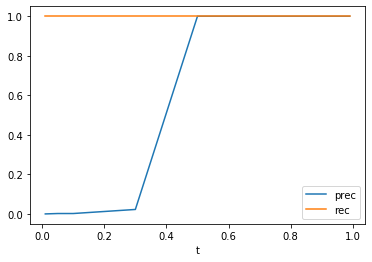

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

#exp_df = pd.read_csv('results_data/mh_df.csv')

plot_df = exp_df.melt(id_vars=['t'])

fig, ax = plt.subplots()
labels = []

for key, grp in plot_df.groupby('variable'):
    ax = grp.plot(ax=ax, kind='line', x='t', y='value')
    labels.append(key)
lines, _ = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')
plt.show()

**TODO**: Comment on the behavior of precision and recall as a function of similarity threshold.
Initially when the similarity threshold is low the precision is also low meaning that there is a low number of true positives given the actual results. However, as the similarity threshold aproaches 0.3 the precision drastically increases until it reaches 1.0 around with a similarity threshold of .5. The recall appears to remain constant / perfect at 1, but this is unlikely and is possibly an error in the data. At some point an increase in the similarity threshold would likely impact the predicted results increaseing the number of true positives or false negatives.


In [ ]:
# DELETE 

In [ ]:
from __future__ import division
import os
import re
import random
import time
import binascii
from bisect import bisect_right
from heapq import heappop, heappush

In [112]:
plagiaries = {}

# Open the truth file.
f = open(truth_file, "r")

# For each line of the files...
for line in f:
  
  # Strip the newline character, if present.
    if line[-1] == '\n':
        line = line[0:-1]
      
    docs = line.split(" ")

  # Map the two documents to each other.

    plagiaries[docs[0]] = docs[1]
    plagiaries[docs[1]] = docs[0]


In [113]:
# The current shingle ID value to assign to the next new shingle we 
# encounter. When a shingle gets added to the dictionary, we'll increment this
# value.
curShingleID = 0

# Create a dictionary of the articles, mapping the article identifier (e.g., 
# "t8470") to the list of shingle IDs that appear in the document.
docsAsShingleSets = {};
  
# Open the data file.
f = open(train_file, "r")

docNames = []

t0 = time.time()

totalShingles = 0

for i in range(0, numDocs):
  
  # Read all of the words (they are all on one line) and split them by white
  # space.
    words = f.readline().split(" ") 
  
  # Retrieve the article ID, which is the first word on the line.  
    docID = words[0]
  
  # Maintain a list of all document IDs.  
    docNames.append(docID)
    
    del words[0]  
  
  # 'shinglesInDoc' will hold all of the unique shingle IDs present in the 
  # current document. If a shingle ID occurs multiple times in the document,
  # it will only appear once in the set (this is a property of Python sets).
    shinglesInDoc = set()
  
  # For each word in the document...
for index in range(0, len(words) - 2):
    # Construct the shingle text by combining three words together.
    shingle = words[index] + " " + words[index + 1] + " " + words[index + 2]

    # Hash the shingle to a 32-bit integer.
    #crc = binascii.crc32(shingle) & 0xffffffff
    #crc = CityHash32(shingle) - math.pow(2, 31)
    crc = hash(shingle)
    
    # Add the hash value to the list of shingles for the current document. 
    # Note that set objects will only add the value to the set if the set 
    # doesn't alreadyshingle contain it. 
    shinglesInDoc.add(crc)
  
  # Store the completed list of shingles for this document in the dictionary.
    docsAsShingleSets[docID] = shinglesInDoc
  
  # Count the number of shingles across all documents.
    totalShingles = totalShingles + (len(words) - 2)

# Close the data file.  
f.close()  

# Report how long shingling took.
print('\nShingling ' + str(numDocs) + ' docs took %.2f sec.' % (time.time() - t0))
 
print('\nAverage shingles per doc: %.2f' % (totalShingles / numDocs))


Shingling 1000 docs took 0.04 sec.

Average shingles per doc: 77.28


In [114]:
# Define virtual Triangle matrices to hold the similarity values. For storing
# similarities between pairs, we only need roughly half the elements of a full
# matrix. Using a triangle matrix requires less than half the memory of a full
# matrix, and can protect the programmer from inadvertently accessing one of
# the empty/invalid cells of a full matrix.

# Calculate the number of elements needed in our triangle matrix
numElems = int(numDocs * (numDocs - 1) / 2)

# Initialize two empty lists to store the similarity values. 
# 'JSim' will be for the actual Jaccard Similarity values. 
# 'estJSim' will be for the estimated Jaccard Similarities found by comparing
# the MinHash signatures.
JSim = [0 for x in range(numElems)]
estJSim = [0 for x in range(numElems)]

# Define a function to map a 2D matrix coordinate into a 1D index.
def getTriangleIndex(i, j):
  # If i == j that's an error.
  if i == j:
    sys.stderr.write("Can't access triangle matrix with i == j")
    sys.exit(1)
  # If j < i just swap the values.
  if j < i:
    temp = i
    i = j
    j = temp
  
  # Calculate the index within the triangular array.
  # This fancy indexing scheme is taken from pg. 211 of:
  # http://infolab.stanford.edu/~ullman/mmds/ch6.pdf
  # But I adapted it for a 0-based index.
  # Note: The division by two should not truncate, it
  #       needs to be a float. 
  k = int(i * (numDocs - (i + 1) / 2.0) + j - i) - 1
  
  return k

In [115]:
# In this section, we will directly calculate the Jaccard similarities by 
# comparing the sets. This is included here to show how much slower it is than
# the MinHash approach.

# Calculating the Jaccard similarities gets really slow for large numbers
# of documents.
if numDocs <= 2500:
#if True:
    print("\nCalculating Jaccard Similarities...")

    # Time the calculation.
    t0 = time.time()

    # For every document pair...
    for i in range(0, numDocs):
      
      # Print progress every 100 documents.
        if (i % 100) == 0:
            print("  (" + str(i) + " / " + str(numDocs) + ")")

      # Retrieve the set of shingles for document i.
    s1 = docsAsShingleSets[docNames[i]]
      
    for j in range(i + 1, numDocs):
        # Retrieve the set of shingles for document j.
        s2 = docsAsShingleSets[docNames[j]]
        
        # Calculate and store the actual Jaccard similarity.
        JSim[getTriangleIndex(i, j)] = (len(s1.intersection(s2)) / len(s1.union(s2)))    

    # Calculate the elapsed time (in seconds)
        elapsed = (time.time() - t0)
        
        print("\nCalculating all Jaccard Similarities took %.2fsec" % elapsed)

# Delete the Jaccard Similarities, since it's a pretty big matrix.    
del JSim
    


Calculating Jaccard Similarities...
  (0 / 1000)
  (100 / 1000)
  (200 / 1000)
  (300 / 1000)
  (400 / 1000)
  (500 / 1000)
  (600 / 1000)
  (700 / 1000)
  (800 / 1000)
  (900 / 1000)


In [118]:
# Time this step.
t0 = time.time()

print('\nGenerating random hash functions...')

# Record the maximum shingle ID that we assigned.
maxShingleID = 2**32-1

# We need the next largest prime number above 'maxShingleID'.
# I looked this value up here: 
# http://compoasso.free.fr/primelistweb/page/prime/liste_online_en.php
nextPrime = 4294967311


# Our random hash function will take the form of:
#   h(x) = (a*x + b) % c
# Where 'x' is the input value, 'a' and 'b' are random coefficients, and 'c' is
# a prime number just greater than maxShingleID.

# Generate a list of 'k' random coefficients for the random hash functions,
# while ensuring that the same value does not appear multiple times in the 
# list.
def pickRandomCoeffs(k):
  # Create a list of 'k' random values.
  randList = []
  
  while k > 0:
    # Get a random shingle ID.
    randIndex = random.randint(0, maxShingleID) 
  
    # Ensure that each random number is unique.
    while randIndex in randList:
        randIndex = random.randint(0, maxShingleID) 
    
    # Add the random number to the list.
    randList.append(randIndex)
    k = k - 1
    
    return randList

# For each of the 'numHashes' hash functions, generate a different coefficient 'a' and 'b'.   
coeffA = pickRandomCoeffs(numHashes)
coeffB = pickRandomCoeffs(numHashes)

print('\nGenerating MinHash signatures for all documents...')

# List of documents represented as signature vectors
signatures = []

# Rather than generating a random permutation of all possible shingles, 
# we'll just hash the IDs of the shingles that are *actually in the document*,
# then take the lowest resulting hash code value. This corresponds to the index 
# of the first shingle that you would have encountered in the random order.

# For each document...
for docID in docNames:
  
  # Get the shingle set for this document.
    shingleIDSet = docsAsShingleSets[docID]
  
  # The resulting minhash signature for this document. 
    signature = []
  
  # For each of the random hash functions...
for i in range(0, numHashes):
    
    # For each of the shingles actually in the document, calculate its hash code
    # using hash function 'i'. 
    
    # Track the lowest hash ID seen. Initialize 'minHashCode' to be greater than
    # the maximum possible value output by the hash.
    minHashCode = nextPrime + 1
    
    # For each shingle in the document...
for shingleID in shingleIDSet:
      # Evaluate the hash function.
    hashCode = (coeffA[i] * shingleID + coeffB[i]) % nextPrime 
      
      # Track the lowest hash code seen.
    if hashCode < minHashCode:
        minHashCode = hashCode

    # Add the smallest hash code value as component number 'i' of the signature.
    signature.append(minHashCode)
  
  # Store the MinHash signature for this document.
    signatures.append(signature)

# Calculate the elapsed time (in seconds)
elapsed = (time.time() - t0)
        
print("\nGenerating MinHash signatures took %.2fsec" % elapsed)


Generating random hash functions...

Generating MinHash signatures for all documents...


KeyError: 't120'

In [119]:

print('\nComparing all signatures...')
  
# Creates a N x N matrix initialized to 0.

# Time this step.
t0 = time.time()

# For each of the test documents...
for i in range(0, numDocs):
  # Get the MinHash signature for document i.
  signature1 = signatures[i]
    
  # For each of the other test documents...
  for j in range(i + 1, numDocs):
    
    # Get the MinHash signature for document j.
    signature2 = signatures[j]
    
    count = 0
    # Count the number of positions in the minhash signature which are equal.
    for k in range(0, numHashes):
        count = count + (signature1[k] == signature2[k])
    
    # Record the percentage of positions which matched.    
    estJSim[getTriangleIndex(i, j)] = (count / numHashes)

# Calculate the elapsed time (in seconds)
elapsed = (time.time() - t0)
        
print("\nComparing MinHash signatures took %.2fsec" % elapsed)


Comparing all signatures...


IndexError: list index out of range

In [120]:
# Count the true positives and false positives.
tp = 0
fp = 0
  
threshold = 0.5  
print("\nList of Document Pairs with J(d1,d2) more than", threshold)
print("Values shown are the estimated Jaccard similarity and the actual")
print("Jaccard similarity.\n")
print("Est. J   Act. J")

# For each of the document pairs...
for i in range(0, numDocs):  
for j in range(i + 1, numDocs):
    # Retrieve the estimated similarity value for this pair.
    estJ = estJSim[getTriangleIndex(i, j)]
    
    # If the similarity is above the threshold...
    if estJ > threshold:
    
      # Calculate the actual Jaccard similarity for validation.
        s1 = docsAsShingleSets[docNames[i]]
        s2 = docsAsShingleSets[docNames[j]]
        J = (len(s1.intersection(s2)) / len(s1.union(s2)))
      
      # Print out the match and similarity values with pretty spacing.
        print("  %5s --> %5s   %.2f     %.2f" % (docNames[i], docNames[j], estJ, J))
      
      # Check whether this is a true positive or false positive.
      # We don't need to worry about counting the same true positive twice
      # because we implemented the for-loops to only compare each pair once.
    if plagiaries[docNames[i]] == docNames[j]:
        tp = tp + 1
    else:
        fp = fp + 1

# Display true positive and false positive counts.
print("True positives:  " + str(tp) + " / " + str(int(len(plagiaries.keys()) / 2)))
print("False positives: " + str(fp))

IndentationError: expected an indented block (<ipython-input-120-ab167c4ff068>, line 13)